In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
import pandas as pd
from scipy import signal
from scipy.optimize import curve_fit
import os
from tqdm.notebook import tqdm

In [5]:
#check current working directory
retval = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\NE204


In [6]:
# change directory
os.chdir(r'C:\Users\megas\Documents\Cal\NEFall2022\NE204')

#check current working directory
retwal = os.getcwd()
print ("Current working directory %s" %retval)

Current working directory C:\Users\megas\Documents\Cal\NEFall2022\NE204


In [7]:
#Input the data file and find the keys
f = h5py.File(r'C:\Users\megas\Documents\Cal\NEFall2022\NE204\Co60-1min_11.h5', 'r')

#print the keys for the file path
print(f.keys())
print(f['raw_data'])

<KeysViewHDF5 ['event_data', 'raw_data']>
<HDF5 dataset "raw_data": shape (14395, 62500), type "<u2">


In [8]:
type(f['raw_data'])

h5py._hl.dataset.Dataset

Text(0.5, 1.0, 'Raw Pulse')

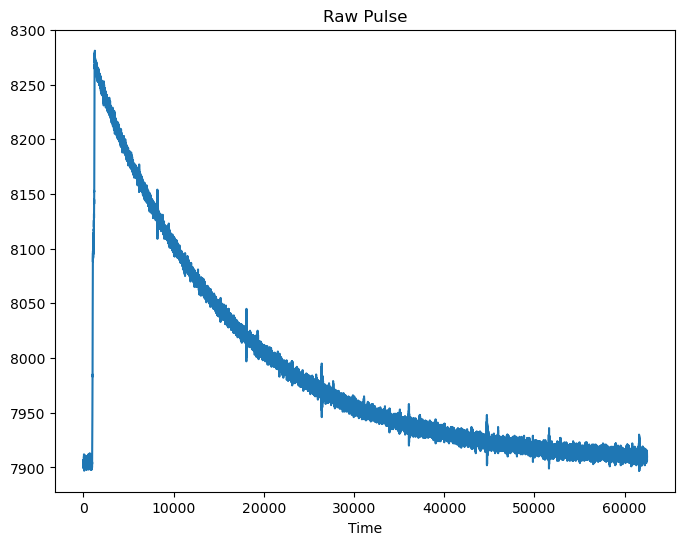

In [9]:
#Plot the raw data
first_pulse = f['raw_data'][0] 
plt.figure(figsize=(8,6))
plt.plot(first_pulse)
plt.xlabel('Time')
plt.title('Raw Pulse')

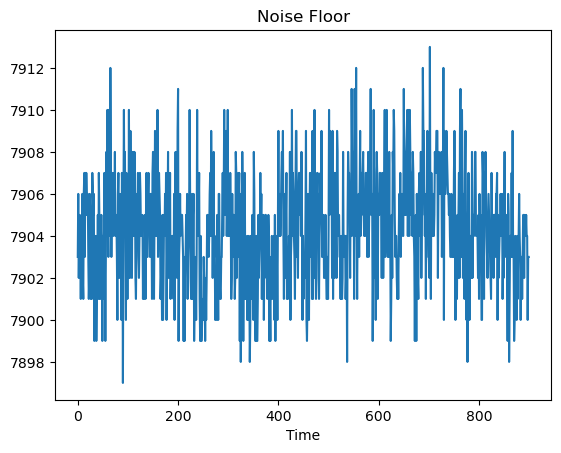

In [10]:
#Background subtraction for the raw data
Floor = first_pulse[0:900]
plt.figure()
plt.plot(Floor)
plt.title("Noise Floor")
plt.xlabel("Time")
Floor_mu = np.mean(Floor)
first_pulse = first_pulse - Floor_mu

Text(0.5, 0, 'Time')

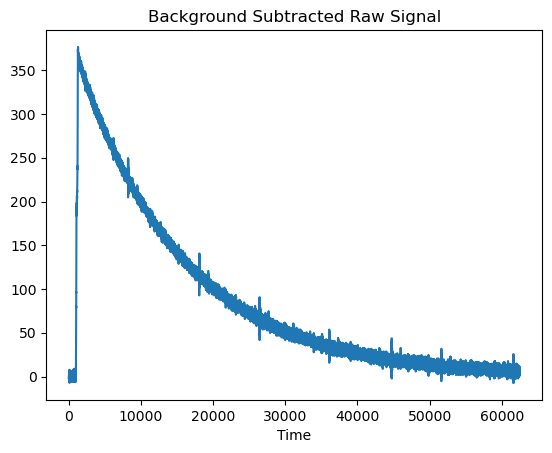

In [11]:
#Plot background subtracted data
plt.figure()
plt.plot(first_pulse)
plt.title("Background Subtracted Raw Signal")
plt.xlabel("Time")

In [12]:
#define an exponential function 
def exp_func(x, a, b, c):
    #returns a times e^(-b times a) + c
    return a * np.exp(-b * x) + c

376.67555555555555 1271


int

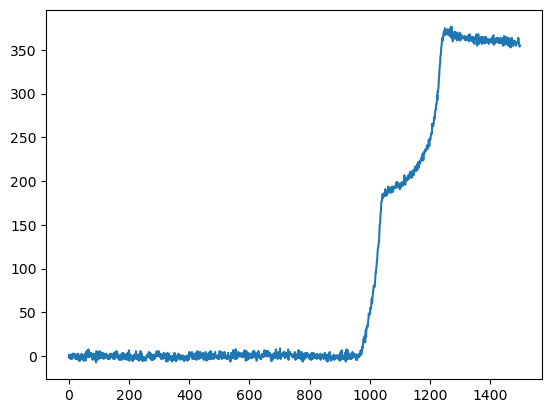

In [13]:
plt.figure()
plt.plot(first_pulse[:1500])
y_max = np.amax(first_pulse)
x_top = np.where(first_pulse == y_max)
exp_start = int(x_top[0])
print(y_max, exp_start)
type(exp_start)

C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.
C:\Users\megas\anaconda3\envs\NE204V1\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in multiply
  after removing the cwd from sys.path.


[3.59184907e+02 6.91949863e-05 2.85461504e+00]


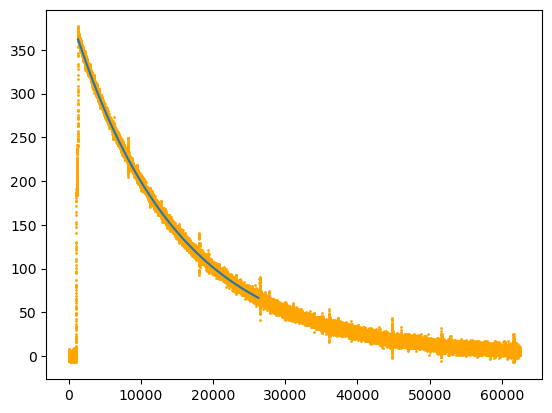

In [14]:
#fit the background subtracted raw data to the exp function
endfit = 25000
x = np.arange(0,endfit)
popt, pcov = curve_fit(exp_func, x, first_pulse[exp_start:exp_start+endfit])
print(popt)

#plot fitted exponential against bkg sub raw data
plt.figure()
plt.plot(range(exp_start,exp_start+len(exp_func(x, *popt))),exp_func(x, *popt))
plt.scatter(np.arange(0,len(first_pulse)),first_pulse, s=1, color='orange')

In [15]:
#find the decay constant
tau = 1/popt[1]
print("The decay constant, tau, is", tau)

The decay constant, tau, is 14451.914127061134


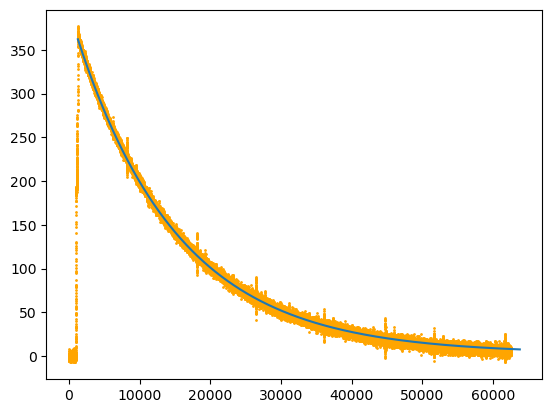

In [16]:
#extrapolate the fit for the whole range of data
raw_range = np.arange(0,len(first_pulse))
exp_pulse = exp_func(raw_range, *popt)
plt.figure()
plt.plot(np.arange(exp_start,exp_start+len(first_pulse)), exp_pulse)
plt.scatter(np.arange(0,len(first_pulse)),first_pulse, s=1, color='orange')

In [20]:
#Setting up the trapezoidal convolution operator
t = np.linspace(0,len(exp_pulse),len(exp_pulse))
T1 = 15000 #placeholder
T2 = 15000 #placeholder
def truncated_ramp(t, T1):
    #the truncated ramp convolution function
    return np.piecewise(t,[t < 0, ((t>=0) & (t<=T1)), t > T1], [0, t, 0])

def moving_average(t, T2):
    #the moving average (square) convolution function
    return np.piecewise(t, [t < 0, ((t>=0) & (t<=T2)), t > T2], [0, 1, 0])

def trap_conv(t, T1, T2, tau):
    #linear combination of truncated ramp and moving average 
    return truncated_ramp(t, T1) + tau*moving_average(t, T2) + (T1 - tau)*moving_average(t - T1, T2) - truncated_ramp(t - T2, T1)

conv_signal = np.convolve(exp_pulse, trap_conv(t, T1, T2, tau))
plt.figure()
plt.plot(conv_signal)
plt.title("Trapezoidal Pulse")


ValueError: NumPy boolean array indexing assignment cannot assign 62500 input values to the 15000 output values where the mask is true